In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from tqdm import tqdm
from torchsummary import summary
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


# Data preparation

In [3]:
# Hyperparameters
batch_size = 256
img_size = 28
channels = 1
latent_dim = 2
# num_epochs = 500
num_epochs = 5

transform = transforms.Compose(
    [
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
    ]
)

dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True,
)

In [4]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

Training samples: 48000, Validation samples: 12000


# Modeling

In [5]:
# Define the Variational Autoencoder (VAE) in PyTorch
class VAE(nn.Module):
    def __init__(self, channels, latent_dim):
        super(VAE, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)

        self.flatten_dim = 64 * (img_size // 4) * (img_size // 4)
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, self.flatten_dim)
        self.deconv1 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            32, 16, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.conv_final = nn.Conv2d(16, channels, kernel_size=3, padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.flatten_dim)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        x = F.relu(self.fc_decode(z))
        x = x.view(-1, 64, (img_size // 4), (img_size // 4))
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = torch.sigmoid(self.conv_final(x))
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [6]:
def loss_function(recon_x, x, mu, log_var, B=1000):
    # Flatten tensors for MSE calculation
    recon_x_flat = recon_x.view(recon_x.size(0), -1)
    x_flat = x.view(x.size(0), -1)

    # Calculate MSE (per element average)
    mse_out = F.mse_loss(recon_x_flat, x_flat, reduction="mean")

    # Scale by input dimensions
    reconstruction_loss = mse_out * x.shape[1] * x.shape[2] * x.shape[3]

    # Calculate KL divergence
    kl_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), axis=1)

    # Compute final loss (adding B*recon_loss + kl_loss)
    total_loss = B * reconstruction_loss + torch.mean(kl_loss)
    return total_loss, reconstruction_loss, torch.mean(kl_loss)

# Model training

In [7]:
# Create model, optimizer, etc.
model = VAE(channels, latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [8]:
%%time

import os
from datetime import datetime

# Create a log directory if it doesn't exist
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)

# Create a log file with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_file = os.path.join(log_dir, f"training_log_{timestamp}.txt")

# Open the log file
with open(log_file, "w") as f:
    f.write(f"Training started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: VAE with latent_dim={latent_dim}\n")
    f.write(f"Batch size: {batch_size}, Image size: {img_size}x{img_size}\n")
    f.write(f"Total epochs: {num_epochs}\n\n")
    f.write("Epoch,Avg_Loss,Recon_Loss,KL_Loss\n")

# Training loop with logging
for epoch in range(num_epochs):
    train_loss = 0.0
    epoch_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for data, _ in epoch_bar:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, recon_loss, kl_loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        epoch_bar.set_postfix(loss=loss.item())

    # Calculate average loss
    avg_loss = train_loss / len(train_loader.dataset)

    # Print epoch summary
    print(
        f"Epoch {epoch+1}/{num_epochs} Loss per sample: {avg_loss:.4f}"
        f"Recon Loss: {recon_loss.item():.4f} KL Loss: {kl_loss.item():.4f}"
    )

    # Save to log file
    with open(log_file, "a") as f:
        f.write(
            f"{epoch+1},{avg_loss:.6f},{recon_loss.item():.6f},{kl_loss.item():.6f}\n"
        )

# Log training completion
with open(log_file, "a") as f:
    f.write(f"\nTraining completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

print(f"Training log saved to {log_file}")

Epoch 1/5 Loss per sample: 310.3999Recon Loss: 52.8979 KL Loss: 18.0465


Epoch 2/5 Loss per sample: 181.2117Recon Loss: 44.2948 KL Loss: 16.1430


Epoch 3/5 Loss per sample: 164.0979Recon Loss: 41.9277 KL Loss: 15.3877


Epoch 4/5 Loss per sample: 154.9804Recon Loss: 36.0725 KL Loss: 15.3755


Epoch 5/5 Loss per sample: 150.0247Recon Loss: 34.9088 KL Loss: 15.3022
Training log saved to logs/training_log_20250324_163017.txt
CPU times: user 14min 53s, sys: 4min 5s, total: 18min 58s
Wall time: 4min 11s


# Insights calculation

In [9]:
# After training, visualize the reconstruction on validation images
model.eval()
with torch.no_grad():
    data_iter = iter(val_loader)
    images, _ = next(data_iter)
    images = images.to(device)
    recon_images, _, _ = model(images)

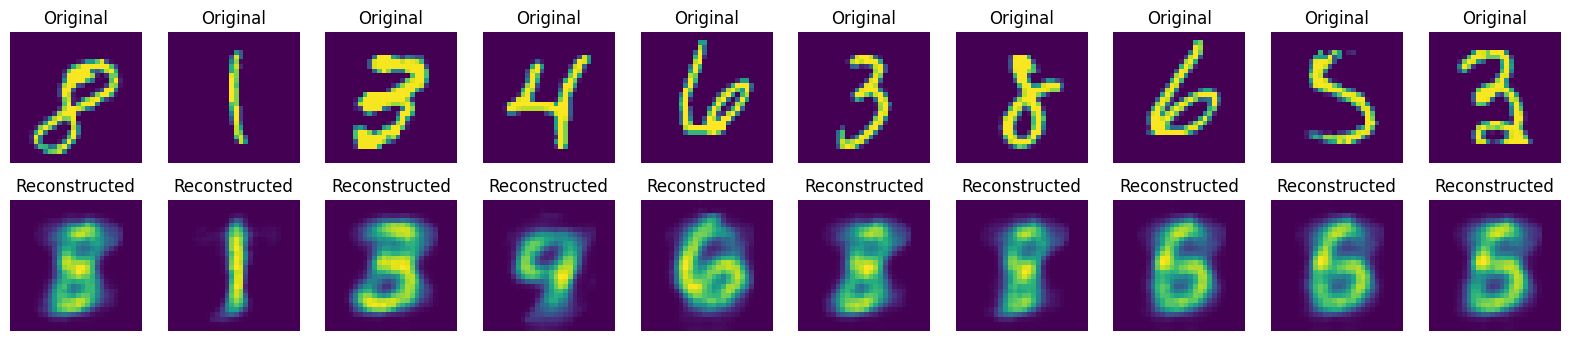

In [10]:
# Plot original and reconstructed images side by side
n = 10  # number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original image: (C,H,W) -> (H,W,C)
    orig = images[i].cpu().permute(1, 2, 0).numpy()
    recon = recon_images[i].cpu().permute(1, 2, 0).numpy()

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(orig)
    plt.title("Original")
    plt.axis("off")

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon)
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()